In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score, roc_auc_score

import shap

from joblib import dump, load
import catboost as cb
from catboost import CatBoostClassifier

In [2]:
df_list = []
campaign_list = ['1458', '2259', '2261', '2821', '2997', '3358', '3476']
for campaign in campaign_list:
    df = pd.read_csv(f'/Users/sujitkhanna/Desktop/Courses/capstone/code base/rtb_exploration/campaign/test/{campaign}/train_5min_agg.csv')
    df["campaign"] = int(campaign)
    df.drop(columns=["Unnamed: 0"], inplace=True)
    daily_budget = df["payprice"].iloc[:12*24].sum()
    df["daily_budget"] = daily_budget
    df_list.append(df)

full_df = pd.concat(df_list, axis=0)
full_df.shape

(5426, 13)

In [3]:
full_df["datetime"] = pd.to_datetime(full_df["datetime"])
full_df.head()

,datetime,weekday,hour,bid count,payprice,click,ctr,campaign,daily_budget,bid count (t-1),payprice (t-1),click (t-1),ctr (t-1)
0,2013-06-13 00:05:00,4.0,0.0,357,47.173669,1,0.280112,1458,19430.033592,NaN,NaN,NaN,NaN
1,2013-06-13 00:10:00,4.0,0.0,1214,55.963756,1,0.082372,1458,19430.033592,NaN,NaN,NaN,NaN
2,2013-06-13 00:15:00,4.0,0.0,283,57.968198,0,0.000000,1458,19430.033592,NaN,NaN,NaN,NaN
3,2013-06-13 00:20:00,4.0,0.0,354,36.709040,0,0.000000,1458,19430.033592,NaN,NaN,NaN,NaN
4,2013-06-13 00:25:00,4.0,0.0,1739,50.522714,1,0.057504,1458,19430.033592,NaN,NaN,NaN,NaN


In [4]:
full_df["daily_budget"].unique()

array([19430.03359152, 22809.41228663, 17848.79704684, 24661.07777917,
       17070.56679499,  9275.80605565, 24357.23493042])

In [5]:
pred_df = full_df.dropna(inplace=False)
pred_df.head()

,datetime,weekday,hour,bid count,payprice,click,ctr,campaign,daily_budget,bid count (t-1),payprice (t-1),click (t-1),ctr (t-1)
0,2013-10-22 00:05:00,2.0,0.0,140,95.921429,0,0.0,2259,22809.412287,438.0,101.974886,0.0,0.0
1,2013-10-22 00:10:00,2.0,0.0,127,90.362205,0,0.0,2259,22809.412287,140.0,95.921429,0.0,0.0
2,2013-10-22 00:15:00,2.0,0.0,140,86.385714,0,0.0,2259,22809.412287,127.0,90.362205,0.0,0.0
3,2013-10-22 00:20:00,2.0,0.0,157,97.490446,0,0.0,2259,22809.412287,140.0,86.385714,0.0,0.0
4,2013-10-22 00:25:00,2.0,0.0,137,100.000000,0,0.0,2259,22809.412287,157.0,97.490446,0.0,0.0


In [6]:
# pred_df = sklearn.utils.shuffle(pred_df)
rolling_window = 500
test_size = 100
#creating data blocks
data_list = []
for i in range(rolling_window, pred_df.shape[0], test_size):
    data_list.append(pred_df.iloc[i-rolling_window:i, :])

In [7]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor


ip_features = ["hour", "bid count (t-1)", "click (t-1)", "payprice (t-1)"]
# ip_features = ["weekday", "hour", "bid count (t-1)","payprice (t-1)","click (t-1)","ctr (t-1)"]
op_features = ["ctr"]
preds_list, true_list, datetime, campaign_list = [], [], [], []
for i,pred_data in enumerate(data_list):
#     pred_data = sklearn.utils.shuffle(pred_data)
    pred_data.index = list(range(pred_data.shape[0]))
    X_train, y_train = pred_data[ip_features].iloc[:rolling_window-test_size], pred_data[op_features].iloc[:rolling_window-test_size]
    X_test, y_test = pred_data[ip_features].iloc[rolling_window-test_size:], pred_data[op_features].iloc[rolling_window-test_size:]
    X_datetime = pred_data["datetime"].iloc[rolling_window-test_size:]
    X_campaign = pred_data["campaign"].iloc[rolling_window-test_size:]
#     model = RandomForestRegressor(max_depth=2, random_state=0)
    model = CatBoostRegressor(iterations=10000,
                              learning_rate=0.02)

    # Fit model
#     model.fit(X_train, y_train)
    # # Get predictions
    model.fit(X_train.values, y_train.values, verbose=False)
    preds = model.predict(X_test.values)
    preds_list.append(preds)
    true_list.append(y_test.values)
    datetime.append(X_datetime.values)
    campaign_list.append(X_campaign.values)
    print(f"MAE for rolling window {i} is: {mean_absolute_error(y_test.values,preds)}")

MAE for rolling window 0 is: 0.2652341061450765
MAE for rolling window 1 is: 0.04543419405959382
MAE for rolling window 2 is: 0.04903343486232251
MAE for rolling window 3 is: 0.07010756411499423
MAE for rolling window 4 is: 0.05527602332173347
MAE for rolling window 5 is: 0.07003509357545672
MAE for rolling window 6 is: 0.044765904391750995
MAE for rolling window 7 is: 0.042450515945913446
MAE for rolling window 8 is: 0.04632746174354686
MAE for rolling window 9 is: 0.06808357980340363
MAE for rolling window 10 is: 0.047046536698193676
MAE for rolling window 11 is: 0.055119440208070455
MAE for rolling window 12 is: 0.09162457148107057
MAE for rolling window 13 is: 0.07763434789545567
MAE for rolling window 14 is: 0.11908607394541297
MAE for rolling window 15 is: 0.11391558047070655
MAE for rolling window 16 is: 0.10013332379616319
MAE for rolling window 17 is: 0.12226820556869504
MAE for rolling window 18 is: 0.06577255144741301
MAE for rolling window 19 is: 0.09374115227337068
MAE for

In [8]:
preds_ary = np.asarray(preds_list).astype(float)
preds_ary = preds_ary.flatten()
y_test_ary = np.asarray(true_list).astype(float)
y_test_ary = y_test_ary.flatten()
y_test_date = np.asarray(datetime).astype(str)
y_test_date = y_test_date.flatten()
y_test_camp = np.asarray(campaign_list).astype(str)
y_test_camp = y_test_camp.flatten()


y_test_ary[np.argmax(y_test_ary)] = 0
preds_ary[np.where(preds_ary<0)] = 0
print(f"MAE for the entire campaign is: {mean_absolute_error(preds_ary,y_test_ary)}")

MAE for the entire campaign is: 0.11784834329749741


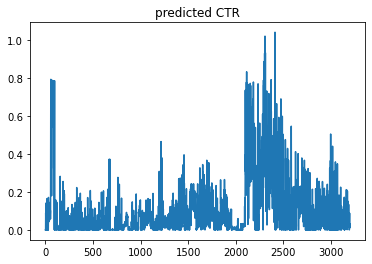

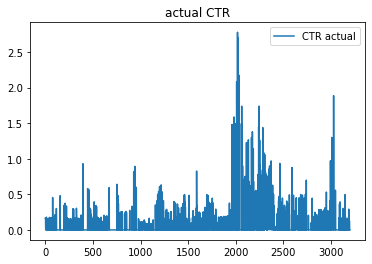

In [9]:
fig = plt.figure()
ax = plt.axes()
plt.plot(list(range(preds_ary.shape[0])),preds_ary , label='CTR pred')
plt.title("predicted CTR")
plt.show()
plt.plot(list(range(y_test_ary.shape[0])),y_test_ary , label='CTR actual')
plt.title("actual CTR")
plt.legend()
plt.show()

In [10]:
ctr_pred_df = pd.DataFrame({"datetime":y_test_date, "ctr_pred":preds_ary, "campaign":y_test_camp})
ctr_pred_df["datetime"] = pd.to_datetime(ctr_pred_df["datetime"])
ctr_pred_df["campaign"] = ctr_pred_df["campaign"].astype('int64')
ctr_pred_df.head()

,datetime,ctr_pred,campaign
0,2013-10-23 13:25:00,0.000000,2259
1,2013-10-23 13:30:00,0.000000,2259
2,2013-10-23 13:35:00,0.000000,2259
3,2013-10-23 13:40:00,0.089711,2259
4,2013-10-23 13:45:00,0.013078,2259


In [11]:
full_df["campaign"].dtype

dtype('int64')

In [12]:
final_df = pd.merge(ctr_pred_df, full_df, how="left", on=["datetime", "campaign"])
final_df.head()

,datetime,ctr_pred,campaign,weekday,hour,bid count,payprice,click,ctr,daily_budget,bid count (t-1),payprice (t-1),click (t-1),ctr (t-1)
0,2013-10-23 13:25:00,0.000000,2259,3.0,13.0,600,113.518333,1,0.166667,22809.412287,650.0,105.723077,0.0,0.000000
1,2013-10-23 13:30:00,0.000000,2259,3.0,13.0,593,115.403035,1,0.168634,22809.412287,600.0,113.518333,1.0,0.166667
2,2013-10-23 13:35:00,0.000000,2259,3.0,13.0,577,114.077990,0,0.000000,22809.412287,593.0,115.403035,1.0,0.168634
3,2013-10-23 13:40:00,0.089711,2259,3.0,13.0,570,118.284211,0,0.000000,22809.412287,577.0,114.077990,0.0,0.000000
4,2013-10-23 13:45:00,0.013078,2259,3.0,13.0,520,118.600000,0,0.000000,22809.412287,570.0,118.284211,0.0,0.000000


In [13]:
# final_df[final_df.isnull()==False]
final_df.shape

(3200, 14)

In [14]:
final_df = final_df.rename(columns={"hour":"tod", "click (t-1)":"tc_prev", "ctr (t-1)":"ctr_prev",
                                    "bid count (t-1)":"total_bids_prev", "payprice (t-1)":"avg_bid_price_prev",
                                    "payprice":"cur_avg_bid_price", "bid count":"total_bids_cur"})
final_df["episode_key"] = final_df["campaign"].astype(str) + '_' + final_df["weekday"].astype(str)
final_df.head()

,datetime,ctr_pred,campaign,weekday,tod,total_bids_cur,cur_avg_bid_price,click,ctr,daily_budget,total_bids_prev,avg_bid_price_prev,tc_prev,ctr_prev,episode_key
0,2013-10-23 13:25:00,0.000000,2259,3.0,13.0,600,113.518333,1,0.166667,22809.412287,650.0,105.723077,0.0,0.000000,2259_3.0
1,2013-10-23 13:30:00,0.000000,2259,3.0,13.0,593,115.403035,1,0.168634,22809.412287,600.0,113.518333,1.0,0.166667,2259_3.0
2,2013-10-23 13:35:00,0.000000,2259,3.0,13.0,577,114.077990,0,0.000000,22809.412287,593.0,115.403035,1.0,0.168634,2259_3.0
3,2013-10-23 13:40:00,0.089711,2259,3.0,13.0,570,118.284211,0,0.000000,22809.412287,577.0,114.077990,0.0,0.000000,2259_3.0
4,2013-10-23 13:45:00,0.013078,2259,3.0,13.0,520,118.600000,0,0.000000,22809.412287,570.0,118.284211,0.0,0.000000,2259_3.0


In [15]:
store_loc = "./data/rtb_store_full_test_5min.h5"
with pd.HDFStore(store_loc,  mode='w') as store:
    store.put(key='full_df_w_unique_key', value=final_df, data_columns= final_df.columns, format='table')

In [16]:
final_df["daily_budget"].unique()

array([22809.41228663, 17848.79704684, 24661.07777917, 17070.56679499,
        9275.80605565, 24357.23493042])